In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
from matplotlib import font_manager

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="../pytorch/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root="../pytorch/data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [25]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super(Encoder, self).__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, decoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoded_lin = nn.Sequential(
            nn.Linear(decoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU6(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoded_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [26]:
encode = Encoder(encoded_space_dim=4, fc2_input_dim=128).to(device)
decoder = Decoder(decoded_space_dim=4, fc2_input_dim=128).to(device)

params_to_optimize = [
    {"params": encode.parameters()},
    {"params": decoder.parameters()},
]
optim_ob = optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [27]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0.0, 1.0)
    return noisy

In [28]:
def train_epoch(
        encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3
):
    encoder.train()
    decoder.train()
    train_loss = []

    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [29]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_noisy = add_noise(image_batch, noise_factor)
            image_noisy = image_noisy.to(device)
            encoded_data = encoder(image_noisy)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [30]:
font_fname = "C:/Windows/Fonts/malgun.ttf"
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [31]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("original image")
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("noisy image")
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("reconstructed image")
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3
    )
    plt.show()

Epoch 1/30

 Epoch 1/30,	Train Loss: 0.082,	Test Loss: 0.051


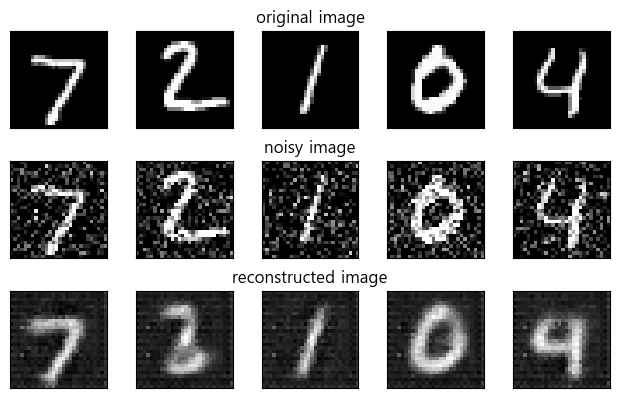

Epoch 2/30

 Epoch 2/30,	Train Loss: 0.055,	Test Loss: 0.045


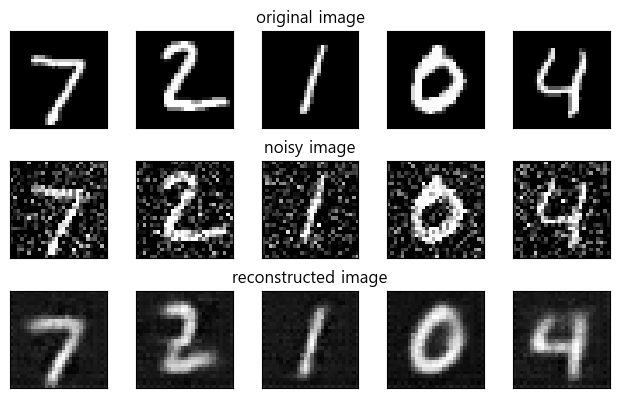

Epoch 3/30

 Epoch 3/30,	Train Loss: 0.053,	Test Loss: 0.043


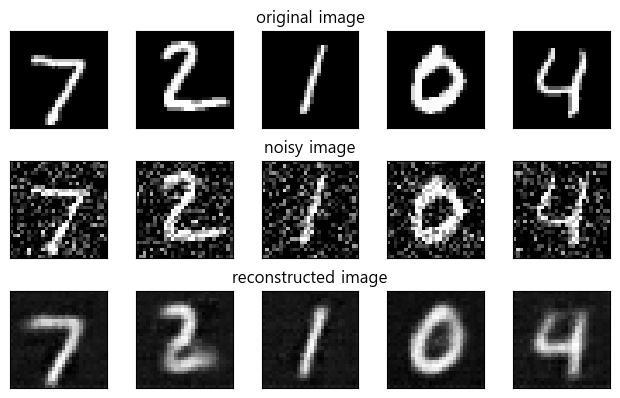

Epoch 4/30

 Epoch 4/30,	Train Loss: 0.053,	Test Loss: 0.043


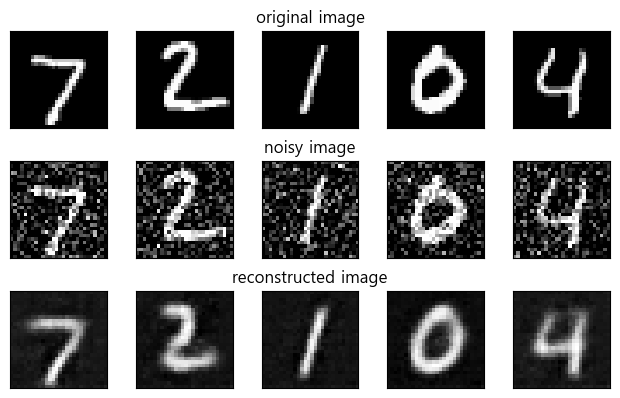

Epoch 5/30

 Epoch 5/30,	Train Loss: 0.052,	Test Loss: 0.042


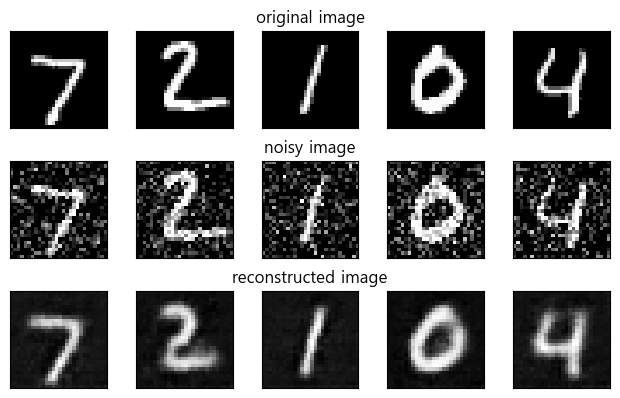

Epoch 6/30

 Epoch 6/30,	Train Loss: 0.052,	Test Loss: 0.041


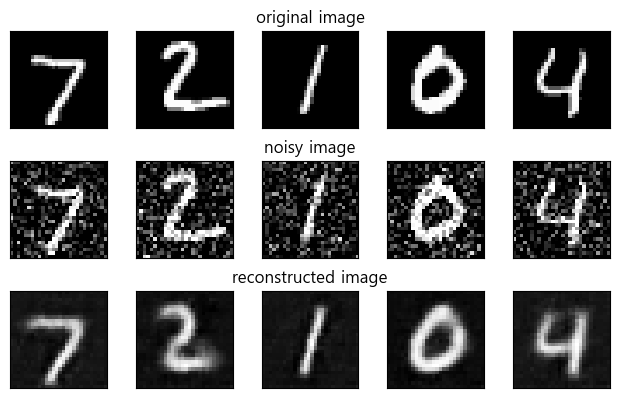

Epoch 7/30

 Epoch 7/30,	Train Loss: 0.051,	Test Loss: 0.041


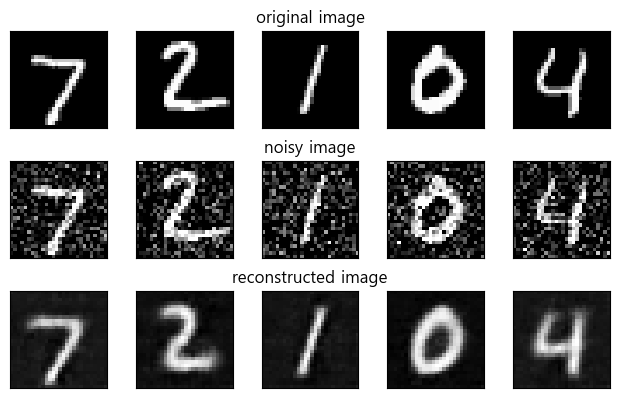

Epoch 8/30

 Epoch 8/30,	Train Loss: 0.051,	Test Loss: 0.041


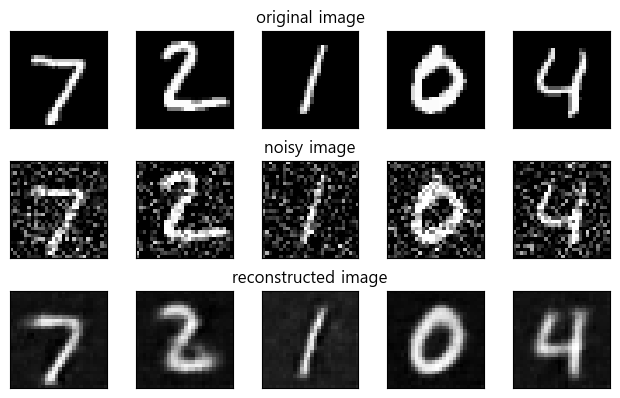

Epoch 9/30

 Epoch 9/30,	Train Loss: 0.051,	Test Loss: 0.041


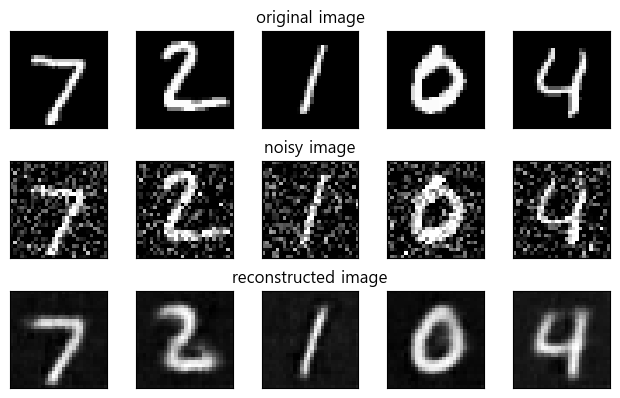

Epoch 10/30

 Epoch 10/30,	Train Loss: 0.051,	Test Loss: 0.040


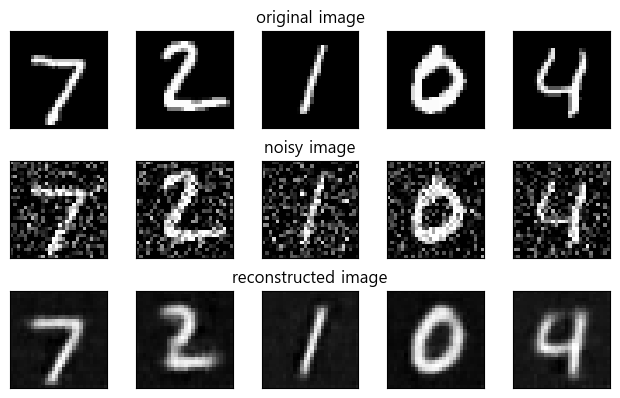

Epoch 11/30

 Epoch 11/30,	Train Loss: 0.051,	Test Loss: 0.040


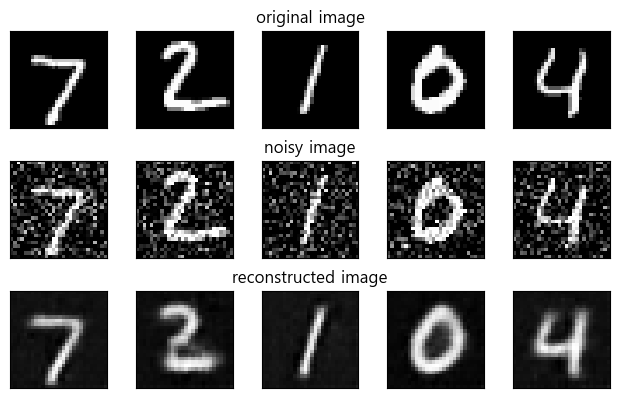

Epoch 12/30

 Epoch 12/30,	Train Loss: 0.051,	Test Loss: 0.040


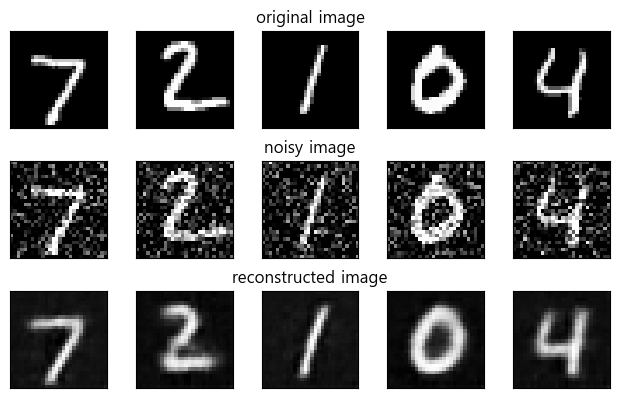

Epoch 13/30

 Epoch 13/30,	Train Loss: 0.051,	Test Loss: 0.040


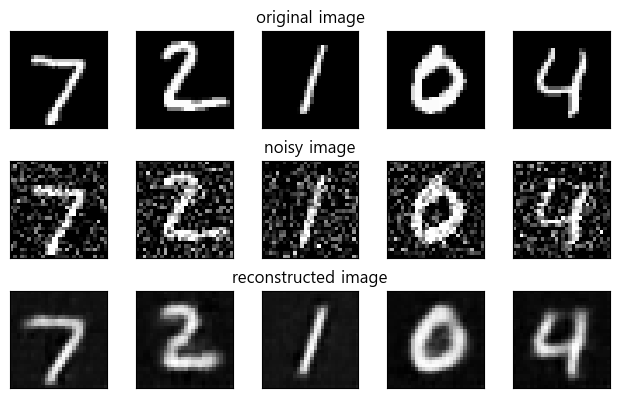

Epoch 14/30

 Epoch 14/30,	Train Loss: 0.050,	Test Loss: 0.039


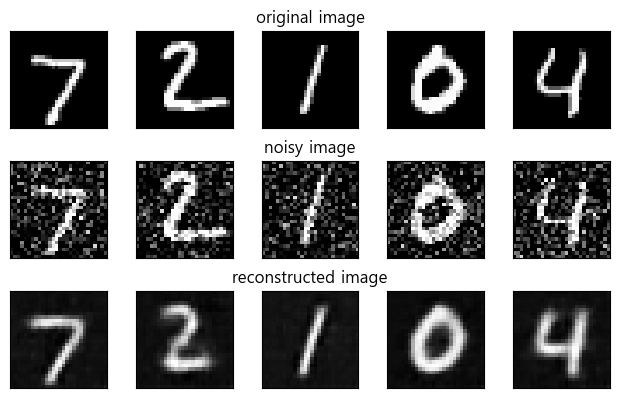

Epoch 15/30

 Epoch 15/30,	Train Loss: 0.050,	Test Loss: 0.040


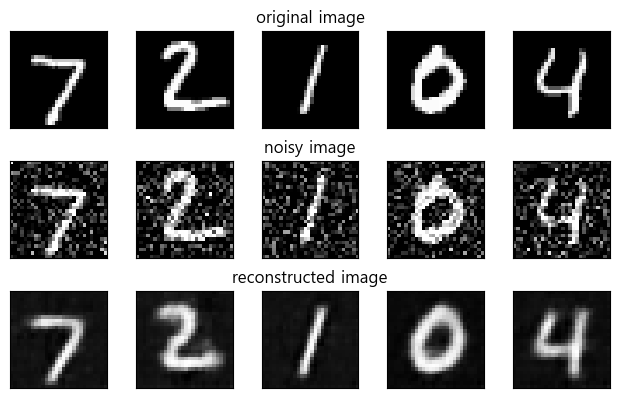

Epoch 16/30

 Epoch 16/30,	Train Loss: 0.050,	Test Loss: 0.039


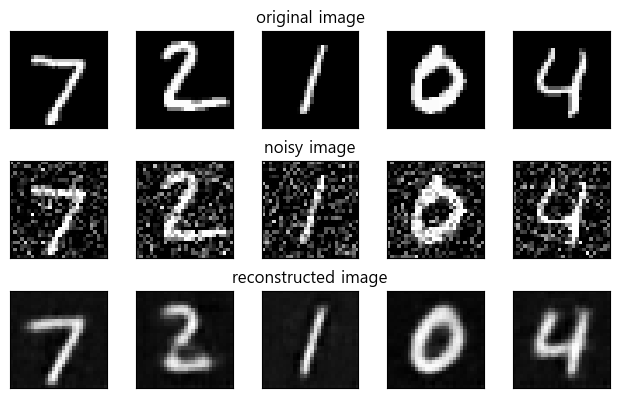

Epoch 17/30

 Epoch 17/30,	Train Loss: 0.050,	Test Loss: 0.039


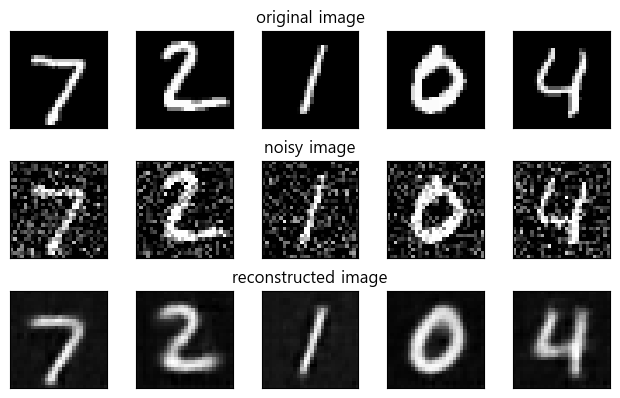

Epoch 18/30

 Epoch 18/30,	Train Loss: 0.050,	Test Loss: 0.039


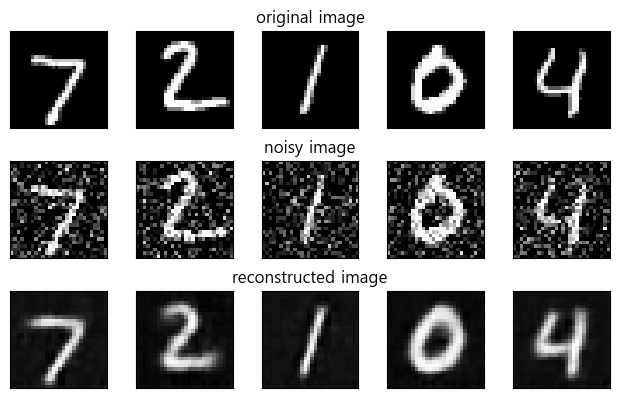

Epoch 19/30

 Epoch 19/30,	Train Loss: 0.050,	Test Loss: 0.039


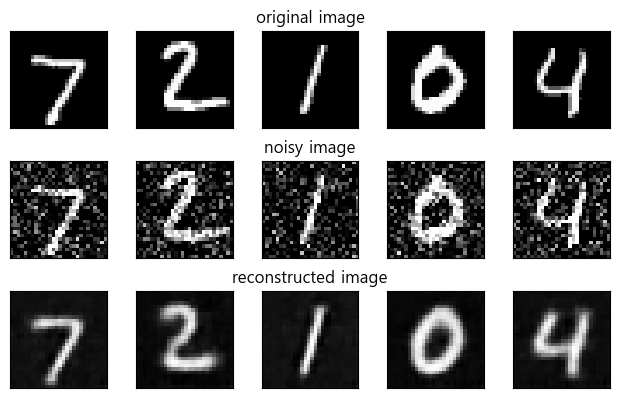

Epoch 20/30

 Epoch 20/30,	Train Loss: 0.050,	Test Loss: 0.039


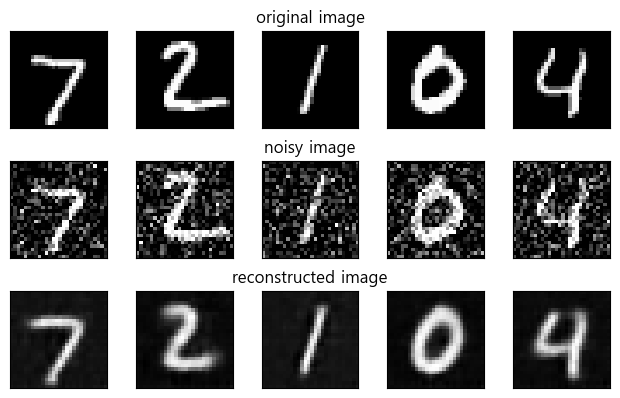

Epoch 21/30

 Epoch 21/30,	Train Loss: 0.050,	Test Loss: 0.039


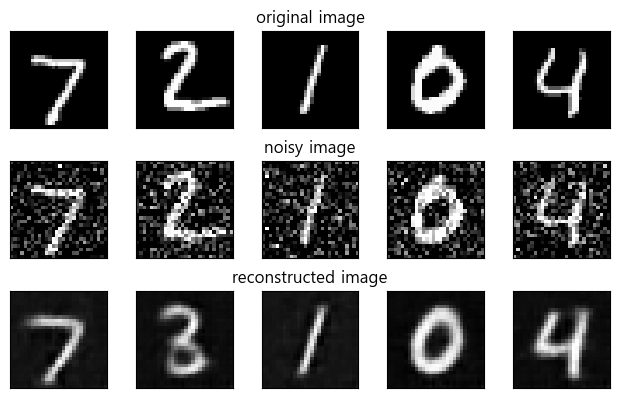

Epoch 22/30

 Epoch 22/30,	Train Loss: 0.050,	Test Loss: 0.039


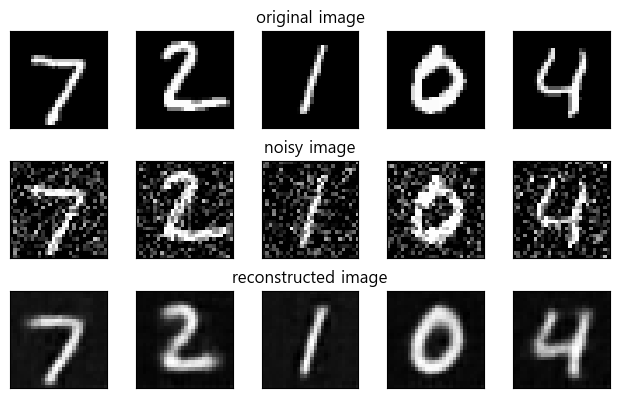

Epoch 23/30

 Epoch 23/30,	Train Loss: 0.050,	Test Loss: 0.039


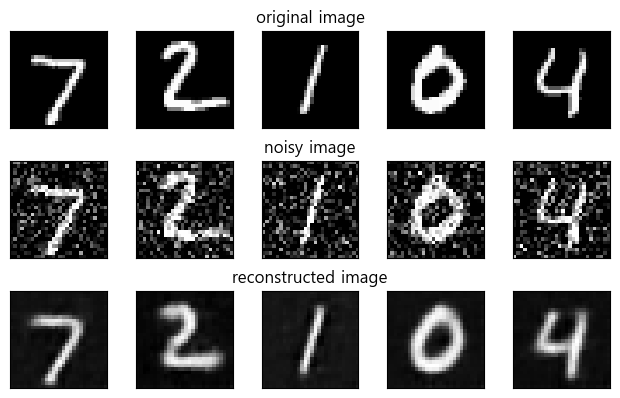

Epoch 24/30

 Epoch 24/30,	Train Loss: 0.050,	Test Loss: 0.039


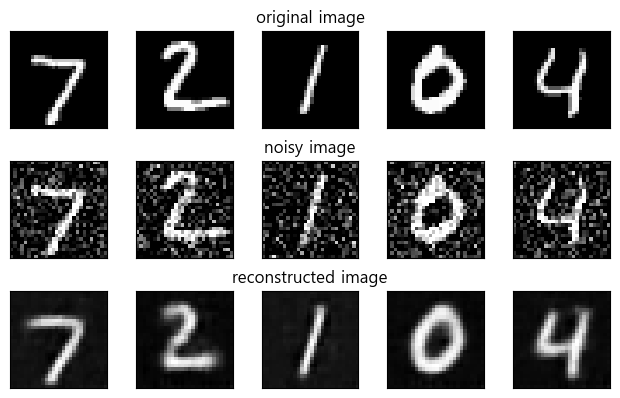

Epoch 25/30

 Epoch 25/30,	Train Loss: 0.050,	Test Loss: 0.039


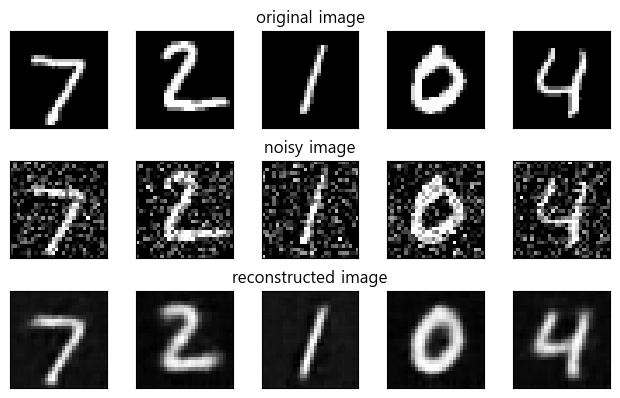

Epoch 26/30

 Epoch 26/30,	Train Loss: 0.050,	Test Loss: 0.038


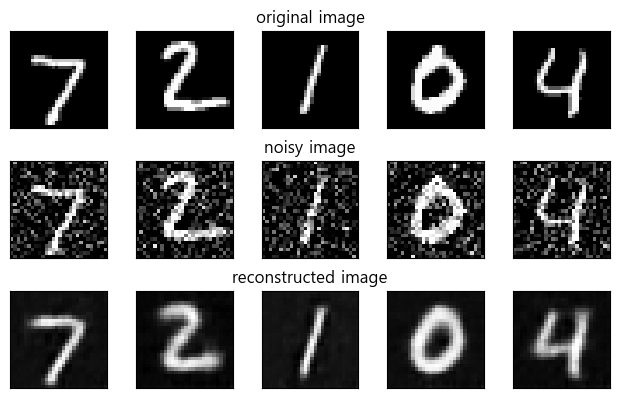

Epoch 27/30

 Epoch 27/30,	Train Loss: 0.050,	Test Loss: 0.038


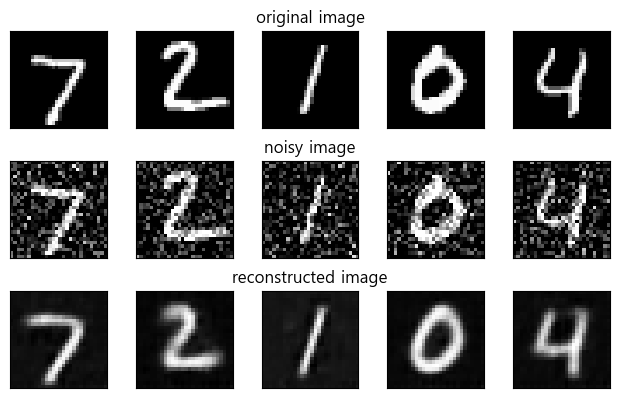

Epoch 28/30

 Epoch 28/30,	Train Loss: 0.050,	Test Loss: 0.038


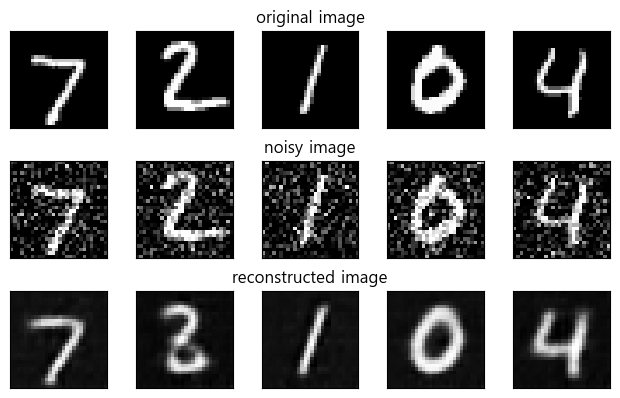

Epoch 29/30

 Epoch 29/30,	Train Loss: 0.050,	Test Loss: 0.038


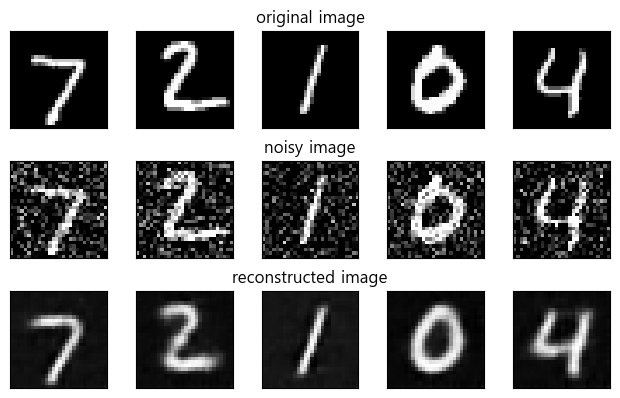

Epoch 30/30

 Epoch 30/30,	Train Loss: 0.049,	Test Loss: 0.038


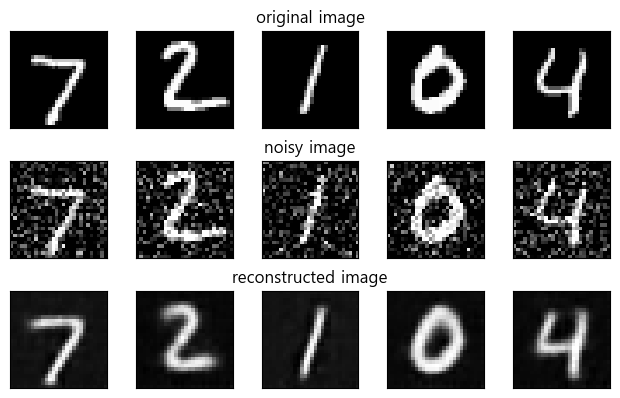

In [32]:
num_epochs = 30
history_da = {"train_loss": [], "test_loss": []}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(
        encode, decoder, device, train_loader, loss_fn, optim_ob, noise_factor=0.3
    )
    val_loss = test_epoch(
        encode, decoder, device, test_loader, loss_fn, noise_factor=0.3
    )
    history_da["train_loss"].append(train_loss)
    history_da["test_loss"].append(val_loss)
    print(f"\n Epoch {epoch+1}/{num_epochs},", end="\t")
    print(f"Train Loss: {train_loss:.3f},", end="\t")
    print(f"Test Loss: {val_loss:.3f}")
    plot_ae_outputs(encode, decoder, noise_factor=0.3)